In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import timm
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


In [9]:
# Load dataset with metadata
df = pd.read_csv("HAM10000/HAM10000_metadata.csv")

# Add file path
df["image_path"] = df["image_id"].apply(lambda x: f"HAM10000/images/{x}.jpg")

# Inspect data
print(df.head())
print(df["dx"].value_counts())

# Encode labels
label_map = {label: idx for idx, label in enumerate(df["dx"].unique())}
df["label"] = df["dx"].map(label_map)
num_classes = len(label_map)
print(label_map)


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                        image_path  
0  vidir_modern  HAM10000/images/ISIC_0027419.jpg  
1  vidir_modern  HAM10000/images/ISIC_0025030.jpg  
2  vidir_modern  HAM10000/images/ISIC_0026769.jpg  
3  vidir_modern  HAM10000/images/ISIC_0025661.jpg  
4  vidir_modern  HAM10000/images/ISIC_0031633.jpg  
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


In [10]:
# Split data into training and validation sets using StratifiedGroupKFold
gkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

train_idx, val_idx = list(gkf.split(df, df["label"], df["lesion_id"]))[0]
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


Train size: 8043, Val size: 1972


In [11]:
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        # transform for data augmentation and preprocessing
        self.transform = transform
        
    # Number of samples in the dataset
    def __len__(self):
        return len(self.df)
    
    # Load and return a sample from the dataset
    # Parameters: idx - index of the sample to retrieve
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row["image_path"])
        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = row["label"]
        
        if self.transform:
            image = self.transform(image=image)["image"]
        # Return image and label as tensors    
        return image, torch.tensor(label, dtype=torch.long)


In [12]:
# Data augmentation and preprocessing
# Show varies versions of the same image using albumentations
train_transform = A.Compose([
    A.RandomResizedCrop((320, 320), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Standard validation transform
val_transform = A.Compose([
    A.Resize(320, 320),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [13]:
# Class balancing using WeightedRandomSampler
train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)

class_counts = train_df["label"].value_counts().sort_index().values
weights = 1.0 / class_counts
sample_weights = [weights[label] for label in train_df["label"]]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [14]:
# Define efficientnetv2 model, loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# TODO: explore different models
model = timm.create_model("efficientnetv2_rw_s", pretrained=True, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2) # TODO: 1e-4 or 5e-4 if overfitting
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


cuda


In [15]:
# Training and validation loops

# Progress bar for training
from tqdm.notebook import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())
    return total_loss / len(loader.dataset), correct / len(loader.dataset), preds, trues

best_val_acc = 0
for epoch in range(10):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, preds, trues = validate(model, val_loader, criterion)
    scheduler.step()
    print(f"Epoch {epoch+1}: Train Acc {train_acc:.3f}, Val Acc {val_acc:.3f}")
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "skin_cancer_model.pth")  # TODO: .pt or .pth
        best_val_acc = val_acc


  0%|          | 0/252 [00:00<?, ?it/s]

C:\Users\spenc\AppData\Local\Temp\ipykernel_11088\832655224.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1: Train Acc 0.569, Val Acc 0.707


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 2: Train Acc 0.804, Val Acc 0.764


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 3: Train Acc 0.861, Val Acc 0.753


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 4: Train Acc 0.898, Val Acc 0.790


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 5: Train Acc 0.917, Val Acc 0.824


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 6: Train Acc 0.928, Val Acc 0.813


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 7: Train Acc 0.946, Val Acc 0.818


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 8: Train Acc 0.953, Val Acc 0.827


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 9: Train Acc 0.959, Val Acc 0.826


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 10: Train Acc 0.960, Val Acc 0.831


              precision    recall  f1-score   support

         bkl       0.70      0.73      0.71       219
          nv       0.93      0.89      0.91      1342
          df       0.84      0.76      0.80        21
         mel       0.53      0.65      0.58       216
        vasc       0.96      0.90      0.93        29
         bcc       0.76      0.81      0.78       101
       akiec       0.60      0.59      0.60        44

    accuracy                           0.83      1972
   macro avg       0.76      0.76      0.76      1972
weighted avg       0.84      0.83      0.84      1972



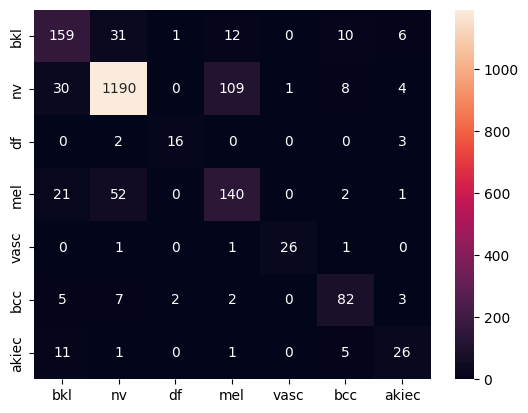

In [16]:
# Model performance visualization
print(classification_report(trues, preds, target_names=label_map.keys()))
sns.heatmap(confusion_matrix(trues, preds), annot=True, fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.show()